# Entropy deep-dive

We'll look at two questions:

1. Theoretically, what is the relationship between entropy and k-factor? For instance, holding the k-factor constant, and letting the data become more or less bimodal, how does the entropy change?
2. Empirically, how much variation do we see in entropy when k-factor is held constant? (And the reverse). Also before and after the pandemic, is there a difference in this entropy-after-controlling-for-k-factor?

In [ ]:
using CSV
using Parquet
using Dates
using CategoricalArrays
using Missings
using Random
using Glob
using Latexify



In [128]:
using Plots
using StatsPlots
using GLM
using DataFrames


Plots.scalefontsizes()
Plots.scalefontsizes(1.5)

In [1]:
include("../code/KFactors.jl")
using .KFactors

In [2]:
data = read_data("../data/all_district_peaks.parquet", "../data/sensor_meta_geo.csv")
nothing

┌ Info: Observations in each period
│   combine(groupby(data, :period), nrow) = 3×2 DataFrame
 Row │ period        nrow    
     │ Cat…          Int64   
─────┼───────────────────────
   1 │ pandemic       365083
   2 │ postpandemic   338894
   3 │ prepandemic   1371886
└ @ Main.KFactors /Users/shzh8108/research/peak-spreading/code/KFactors.jl:90
┌ Info: Before filtering, data has 2075863 rows
└ @ Main.KFactors /Users/shzh8108/research/peak-spreading/code/KFactors.jl:101
┌ Info: Removing sensors days with peak-hour occ above 99th percentile (0.22%)
└ @ Main.KFactors /Users/shzh8108/research/peak-spreading/code/KFactors.jl:129
┌ Info: After filtering, data has 961571 rows
└ @ Main.KFactors /Users/shzh8108/research/peak-spreading/code/KFactors.jl:133


In [3]:
data_prepost = data[in.(data.period, [Set(["prepandemic", "postpandemic"])]) , :]
nothing

## Theoretical look at entropy

We will construct an example where entropy changes while the k-factor is held constant. In particular, the data will become more or less bimodal, while the main peak stays the same.

In [88]:
simulated_dist_1 = zeros(24)
simulated_dist_1[1] = 45

for i = 2:24
    simulated_dist_1[i] = 1
end

simulated_dist_1[12] = 22*2

simulated_dist_2 = zeros(24)
simulated_dist_2[1] = 45
for i = 2:24
    simulated_dist_2[i] = 2
end

simulated_dist_2[12] = 22

22

In [33]:
function entropy2(arr)
    total = sum(arr)
    ent2 = 0
    
    for a in arr
        if a == 0
            continue
        end
        
        p = a / total
        ent2 -= p * log2(p)
    end
    
    return ent2
end

entropy2 (generic function with 1 method)

In [89]:
h1 = entropy2(simulated_dist_1)

2.403889915405273

In [90]:
h2 = entropy2(simulated_dist_2)

3.287741227207261

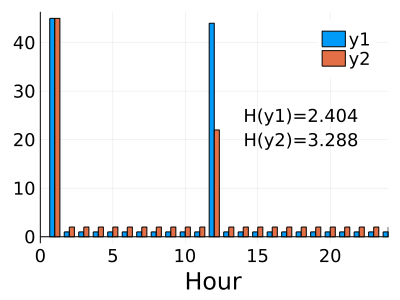

In [141]:
groupedbar([simulated_dist_1 simulated_dist_2], bar_position = :dodge, bar_width=0.7, size=(400, 300), xlim=(0, 24), framestyle=:zerolines, foreground_color_legend=nothing)
annotate!(18, 25, text("H(y1)=$(round(h1, digits=3))",12))
annotate!(18, 20, text("H(y2)=$(round(h2, digits=3))",12))
xlabel!("Hour")
#ylabel!("Value")

## Empirical look at entropy (controlling for k-factors)

We have seen that decreased bimodality can lead to equivalent k-factors with changes in entropy. How does this look in the real data?

Let's start with a simple regression, of `H ~ k`

In [115]:
prepandemic = data_prepost[data_prepost.period .== "prepandemic", :]
postpandemic = data_prepost[data_prepost.period .== "postpandemic", :]

160331×22 DataFrame
    Row │ station  peak_hour_occ  peak_hour_flow  occ_entropy  total_occ  tota ⋯
        │ Int64?   Float64?       Float64?        Float64?     Float64?   Int6 ⋯
────────┼───────────────────────────────────────────────────────────────────────
      1 │  308511      0.0944206       0.0968622      7.71418     2.33         ⋯
      2 │  308512      0.0621179       0.0623372      7.99018    10.6314
      3 │  312010      0.149472        0.0371183      7.8532     25.3994
      4 │  312098      0.0624714       0.0705898      8.05034     8.9593
      5 │  312103      0.0870848       0.0608252      7.96587    23.8354       ⋯
      6 │  312132      0.109709        0.043335       7.77094    26.7207
      7 │  312133      0.0614142       0.054284       8.02063    13.746
      8 │  312134      0.0879062       0.0500634      7.73254    35.5379
      9 │  312139      0.120122        0.0390843      8.01523    20.6065       ⋯
     10 │  312326      0.0710981       0.070176       7.99015    12.3857
     11 │  312346      0.0664191       0.0677437      8.07443    13.2206
   ⋮    │    ⋮           ⋮              ⋮              ⋮           ⋮           ⋱
 160322 │ 1221489      0.0810583       0.0622551      7.81758    24.2011
 160323 │ 1221496      0.0905866       0.0639511      7.76541    27.7359       ⋯
 160324 │ 1221508      0.0832112       0.062234       7.916      24.284
 160325 │ 1221516      0.0796319       0.0583816      7.89338    26.5371
 160326 │ 1221530      0.0782702       0.0572716      7.89834    25.4963
 160327 │ 1221536      0.12164         0.0537672      7.85979    20.1348       ⋯
 160328 │ 1221543      0.0706383       0.058742       7.95373    22.2245
 160329 │ 1221550      0.119655        0.0491509      7.86186    26.065
 160330 │ 1221556      0.115297        0.0545934      7.87233    20.5209
 160331 │ 1221562      0.0905411       0.0254878      7.83267    20.774        ⋯
                                              17 columns and 160310 rows omitted

In [155]:
data_by_station_prepost = combine(groupby(data_prepost, [:station, :period]), :peak_hour_occ => mean => :peak_hour_occ, :occ_entropy => mean => :occ_entropy, :urban => first => :urban, :District => first => :District)
prepandemic_by_station = data_by_station_prepost[data_by_station_prepost.period .== "prepandemic", :]
postpandemic_by_station = data_by_station_prepost[data_by_station_prepost.period .== "postpandemic", :]

8092×6 DataFrame
  Row │ station  period        peak_hour_occ  occ_entropy  urban  District 
      │ Int64?   Cat…          Float64        Float64      Bool   Int64    
──────┼────────────────────────────────────────────────────────────────────
    1 │  308511  postpandemic      0.0985373      7.70589  false         3
    2 │  308512  postpandemic      0.0853268      7.90348  false         3
    3 │  312010  postpandemic      0.0920513      7.94481   true         3
    4 │  312098  postpandemic      0.101153       7.90635   true         3
    5 │  312103  postpandemic      0.0803719      7.95507   true         3
    6 │  312132  postpandemic      0.118518       7.9174    true         3
    7 │  312133  postpandemic      0.0718353      8.01043   true         3
    8 │  312134  postpandemic      0.0859283      7.92501   true         3
    9 │  312139  postpandemic      0.0931256      8.00179   true         3
   10 │  312326  postpandemic      0.0698559      8.01905   true         3
   11 │  312346  postpandemic      0.0666384      8.07265   true         3
  ⋮   │    ⋮          ⋮              ⋮             ⋮         ⋮       ⋮
 8083 │ 1221562  postpandemic      0.0983882      7.87326   true        12
 8084 │ 1201406  postpandemic      0.097243       7.80297   true        12
 8085 │ 1208943  postpandemic      0.161924       6.92389   true        12
 8086 │ 1212282  postpandemic      0.122333       7.6525    true        12
 8087 │ 1212480  postpandemic      0.0941468      7.56062   true        12
 8088 │ 1214238  postpandemic      0.166724       7.48302   true        12
 8089 │ 1220593  postpandemic      0.0842999      7.86929   true        12
 8090 │ 1220832  postpandemic      0.0862141      7.95856   true        12
 8091 │ 1220589  postpandemic      0.130348       7.53769  false        12
 8092 │ 1221254  postpandemic      0.195545       6.64685   true        12
                                                          8071 rows omitted

In [227]:
data_by_station_prepost_med = combine(groupby(data_prepost, [:station, :period]), :peak_hour_occ => median => :peak_hour_occ, :occ_entropy => median => :occ_entropy, :urban => first => :urban, :District => first => :District)
prepandemic_by_station_med = data_by_station_prepost_med[data_by_station_prepost_med.period .== "prepandemic", :]
postpandemic_by_station_med = data_by_station_prepost_med[data_by_station_prepost_med.period .== "postpandemic", :]

nothing

In [174]:
scatter(prepandemic_by_station.peak_hour_occ, (prepandemic_by_station.occ_entropy), label="Pre")
scatter!(postpandemic_by_station.peak_hour_occ, (postpandemic_by_station.occ_entropy), label="Post")

xlabel!("K(station)")
ylabel!("H(station)")

In [211]:
station_pre_post_wide = innerjoin(
    rename(unstack(data_by_station_prepost, :station, :period, :peak_hour_occ), :prepandemic => :pre_k, :postpandemic => :post_k),
    rename(unstack(data_by_station_prepost, :station, :period, :occ_entropy), :prepandemic => :pre_h, :postpandemic => :post_h),
    on=:station
)

station_pre_post_wide.delta_k = station_pre_post_wide.post_k - station_pre_post_wide.pre_k
station_pre_post_wide.delta_h = station_pre_post_wide.post_h - station_pre_post_wide.pre_h
station_pre_post_wide = station_pre_post_wide[.!(ismissing.(station_pre_post_wide.delta_k)), :]

first(station_pre_post_wide, 3)

3×7 DataFrame
 Row │ station  pre_k     post_k     pre_h     post_h    delta_k     delta_h  
     │ Int64?   Float64?  Float64?   Float64?  Float64?  Float64?    Float64? 
─────┼────────────────────────────────────────────────────────────────────────
   1 │  312010  0.110303  0.0920513   7.82322   7.94481  -0.0182516  0.121594
   2 │  312098  0.159157  0.101153    7.6856    7.90635  -0.0580043  0.220749
   3 │  312103  0.109539  0.0803719   7.75687   7.95507  -0.0291668  0.198192

In [229]:
station_pre_post_wide_med = innerjoin(
    rename(unstack(data_by_station_prepost_med, :station, :period, :peak_hour_occ), :prepandemic => :pre_k, :postpandemic => :post_k),
    rename(unstack(data_by_station_prepost_med, :station, :period, :occ_entropy), :prepandemic => :pre_h, :postpandemic => :post_h),
    on=:station
)

station_pre_post_wide_med.delta_k = station_pre_post_wide_med.post_k - station_pre_post_wide_med.pre_k
station_pre_post_wide_med.delta_h = station_pre_post_wide_med.post_h - station_pre_post_wide_med.pre_h
station_pre_post_wide_med = station_pre_post_wide_med[.!(ismissing.(station_pre_post_wide_med.delta_k)), :]

first(station_pre_post_wide_med, 3)

3×7 DataFrame
 Row │ station  pre_k     post_k     pre_h     post_h    delta_k     delta_h  
     │ Int64?   Float64?  Float64?   Float64?  Float64?  Float64?    Float64? 
─────┼────────────────────────────────────────────────────────────────────────
   1 │  312010  0.110033  0.0949012   7.80193   7.94929  -0.0151317  0.147354
   2 │  312098  0.174885  0.0950802   7.66902   7.91236  -0.0798046  0.243337
   3 │  312103  0.109009  0.0781804   7.7577    7.96212  -0.0308284  0.204422

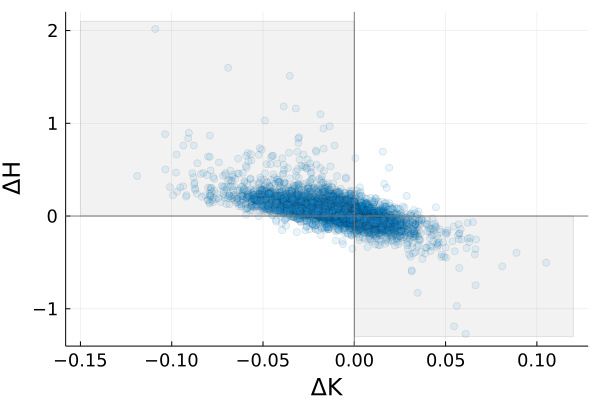

In [226]:
rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])

scatter(station_pre_post_wide.delta_k, station_pre_post_wide.delta_h, alpha=0.1, label=nothing, xlim=[-0.15, 0.12], ylim=[-1.3, 2.1])
vline!([0], label=nothing, color="gray")
hline!([0], label=nothing, color="gray")
xlabel!("ΔK")
ylabel!("ΔH")
plot!(rectangle(0.12,1.3,0,-1.3), opacity=.1, label=nothing, color="gray")
plot!(rectangle(0.15,2.1,-0.15,0), opacity=.1, label=nothing, color="gray")

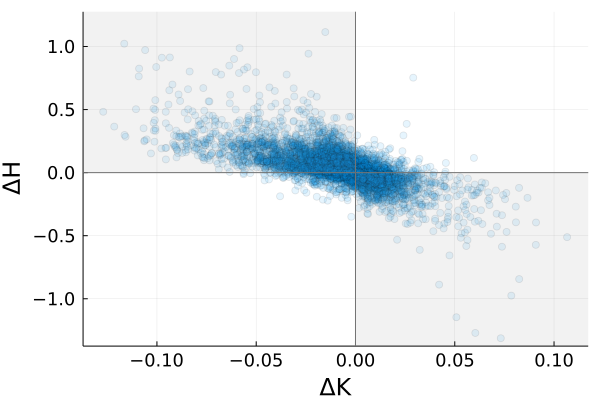

In [234]:
rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])

scatter(station_pre_post_wide_med.delta_k, station_pre_post_wide_med.delta_h, alpha=0.1, label=nothing, xlim=[-0.13, 0.11], ylim=[-1.3, 1.2])
vline!([0], label=nothing, color="gray")
hline!([0], label=nothing, color="gray")
xlabel!("ΔK")
ylabel!("ΔH")
plot!(rectangle(0.12,1.4,0,-1.4), opacity=.1, label=nothing, color="gray")
plot!(rectangle(0.15,1.4,-0.15,0), opacity=.1, label=nothing, color="gray")